In [756]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [757]:
import warnings
warnings.filterwarnings("ignore")

Датасет: [Акции Google](https://www.kaggle.com/datasets/alirezajavid1999/google-stock-2010-2023?select=Google_Stock_Test+%282023%29.csv)

### Columns

- Date: дата торгового дня в формате «yyyy-mm-dd».
- Open: открывая цена акций Google в этот торговый день.
- High: самая высокая цена достигнута в течение торгового дня.
- Low: самая низкая цена, достигнутая в день торговли.
- Close: закрывая цена акций Google в этот торговый день.
- Adj Close: скорректированная цена закрытия, учитывая любые корпоративные действия (например, расколы акций, дивиденды), которые могут повлиять на стоимость акции.
- Volume: объем торгов, представляющий количество акций, торгуемых в этот торговый день.

# Предобработка данных

In [758]:
df_1 = pd.read_csv('data/Google_Stock_Train (2010-2022).csv')
df_2 = pd.read_csv('data/Google_Stock_Test (2023).csv')
df = pd.concat([df_1, df_2])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028


In [759]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index()

In [760]:
df.isna().sum()

index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

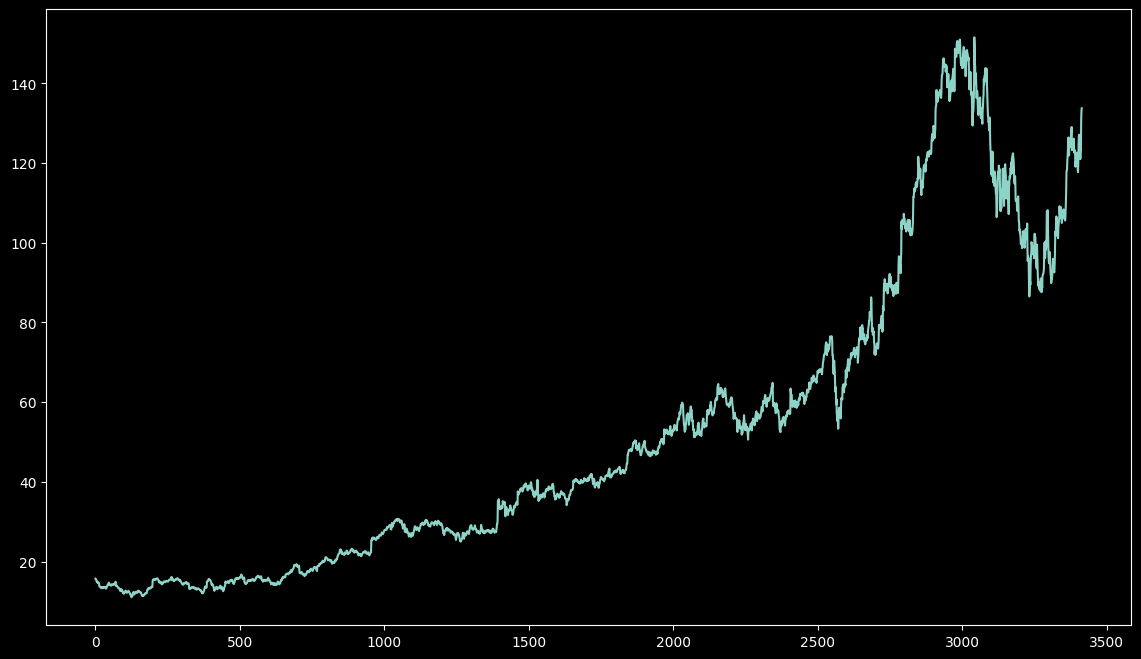

In [761]:
plt.figure(figsize=(14, 8))

plt.plot(df.index, df['High'])

plt.show()

## Разделяем дату

In [762]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

## Убираем колонки кроме предсказываемой High

In [763]:
df.drop([
    'Date', 'Low', 'Close', 'Adj Close', 'Open', 'index', 'Volume'
], inplace=True, axis=1)
df.head()

,High,year,month,day
0,15.753504,2010,1,4
1,15.711712,2010,1,5
2,15.662162,2010,1,6
3,15.265265,2010,1,7
4,15.096346,2010,1,8


## Стандартизация

In [764]:
from sklearn.preprocessing import StandardScaler as Scaler
scaler = Scaler()

scaled_data = scaler.fit_transform(df)
df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
df.head(3)

,High,year,month,day
0,-0.970787,-1.604961,-1.592906,-1.340389
1,-0.971902,-1.604961,-1.592906,-1.226025
2,-0.973224,-1.604961,-1.592906,-1.111661


## Сбор тензоров для обучения

In [765]:
max_year = np.max(df['year'])
max_year

np.float64(1.7100215527303009)

In [766]:
x_train, x_test, y_train, y_test = [], [], [], []

In [767]:
N = 60

In [768]:
for i in range(len(df) - N):
    seq = df.iloc[i:i + N].values  
    target = df['High'].iloc[i + N]
    
    if df['year'].iloc[i + N] == max_year:
        x_test.append(seq)
        y_test.append(target)
    else:
        x_train.append(seq)
        y_train.append(target)

In [769]:
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

# Модели

In [770]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM as RNN

## Deep RNN

In [771]:
model = Sequential([
    RNN(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    
    RNN(64),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(16, activation='relu'),
    Dense(1)  
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.9490 - mae: 0.7399 - val_loss: 1.4303 - val_mae: 1.1621
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.3150 - mae: 0.4318 - val_loss: 0.4479 - val_mae: 0.6455
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1671 - mae: 0.3217 - val_loss: 0.0598 - val_mae: 0.2036
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.1407 - mae: 0.2866 - val_loss: 0.1477 - val_mae: 0.3496
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.1017 - mae: 0.2470 - val_loss: 0.0689 - val_mae: 0.2179
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0939 - mae: 0.2358 - val_loss: 0.0497 - val_mae: 0.1895
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0773 - mae: 0.2137 - val_loss: 0.1866 - val_mae: 0.4077
Epoch 8/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0775 - mae: 0.2150 - val_loss: 0.0698 - val_mae: 0.2229
Epoch 9/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms

In [772]:
def plot_hist(history):
    plt.figure(figsize=(14, 8))

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Loss')
    plt.ylabel('MSE')
    plt.xlabel('Эпоха обучения')

    plt.legend()

    plt.show()

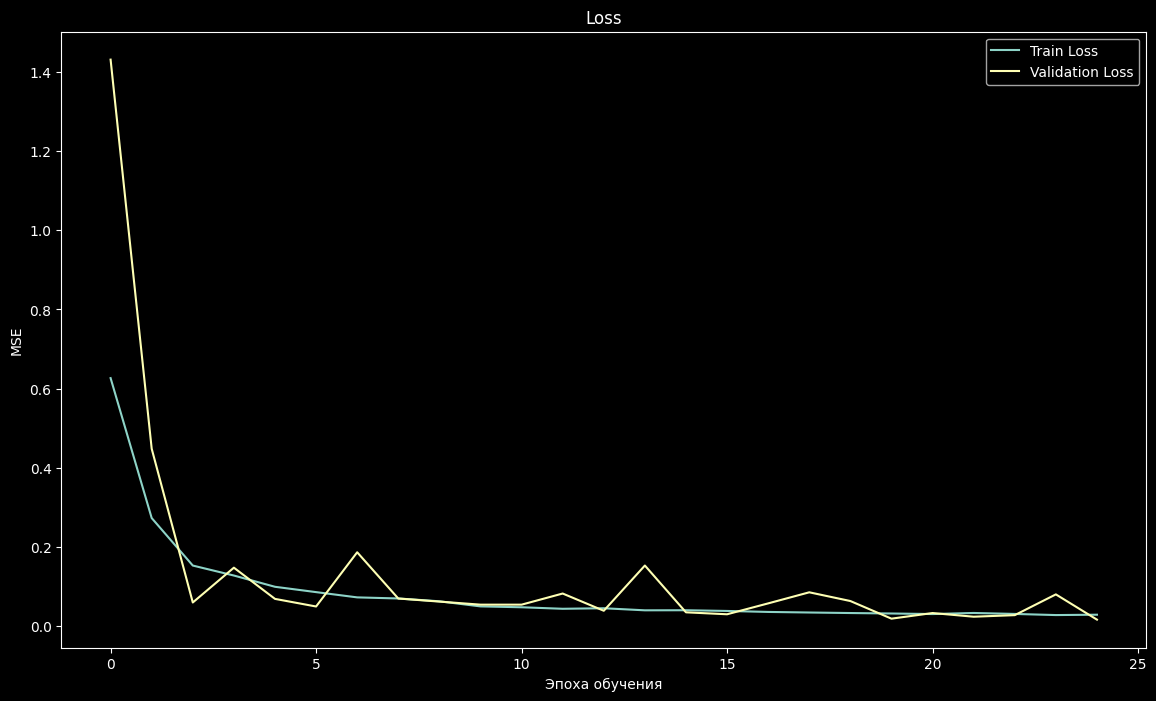

In [773]:
plot_hist(history)

In [774]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [775]:
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
MAE: 0.1015
MSE: 0.0165
R2: 0.8575


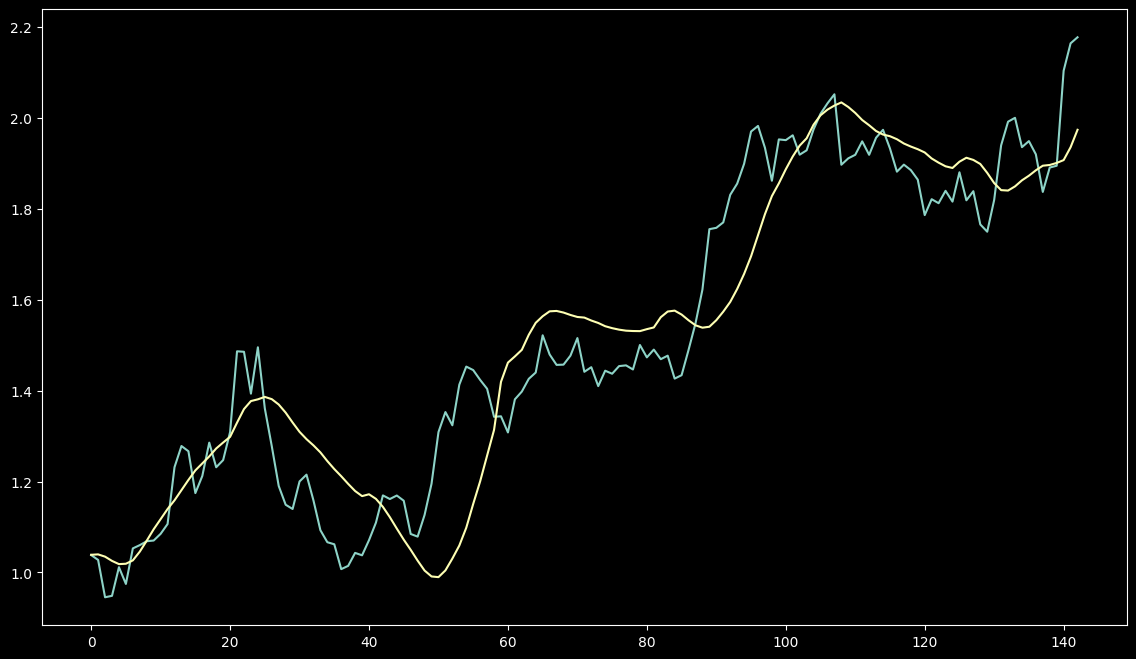

In [776]:
plt.figure(figsize=(14, 8))

plt.plot(y_test, label='Реальные значения')
plt.plot(y_pred, label='Предсказанные значения')

plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


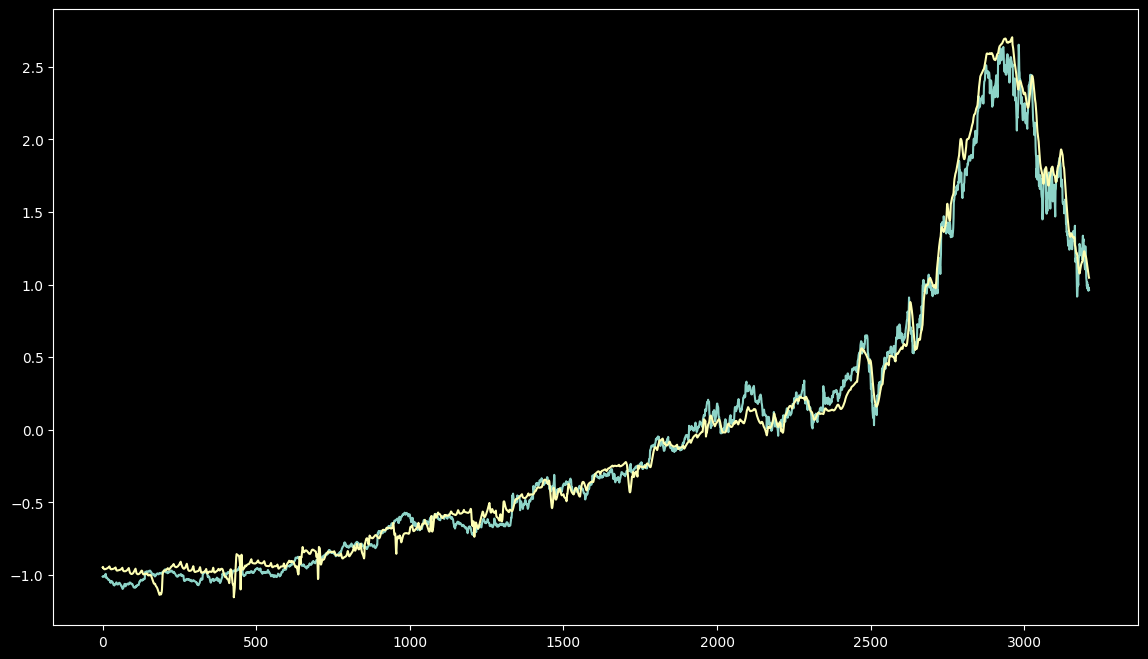

In [777]:
plt.figure(figsize=(14, 8))

plt.plot(y_train, label='Реальные значения')
plt.plot(model.predict(x_train), label='Предсказанные значения')

plt.show()

## Bidirectional RNN

In [785]:
from tensorflow.keras.layers import Bidirectional

In [792]:
model = Sequential([
    Bidirectional(
        RNN(128, return_sequences=True),
        input_shape=(N, 4)
    ),
    BatchNormalization(),
    Dropout(0.3),
    
    Bidirectional(RNN(64)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(16, activation='relu'),
    Dense(1)  
])

In [793]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - loss: 0.9750 - mae: 0.7291 - val_loss: 1.4579 - val_mae: 1.1757
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.2902 - mae: 0.4254 - val_loss: 0.8439 - val_mae: 0.8998
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.1859 - mae: 0.3370 - val_loss: 0.4766 - val_mae: 0.6692
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.1413 - mae: 0.2915 - val_loss: 0.3328 - val_mae: 0.5548
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 0.1073 - mae: 0.2541 - val_loss: 0.0616 - val_mae: 0.1962
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0852 - mae: 0.2229 - val_loss: 0.0714 - val_mae: 0.2151
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.0688 - mae: 0.2021 - val_loss: 0.3683 - val_mae: 0.5701
Epoch 8/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0496 - mae: 0.1736 - val_loss: 0.2254 - val_mae: 0.4577
Epoch 9/25
101/101 ━━━━━━━━━━━━━━

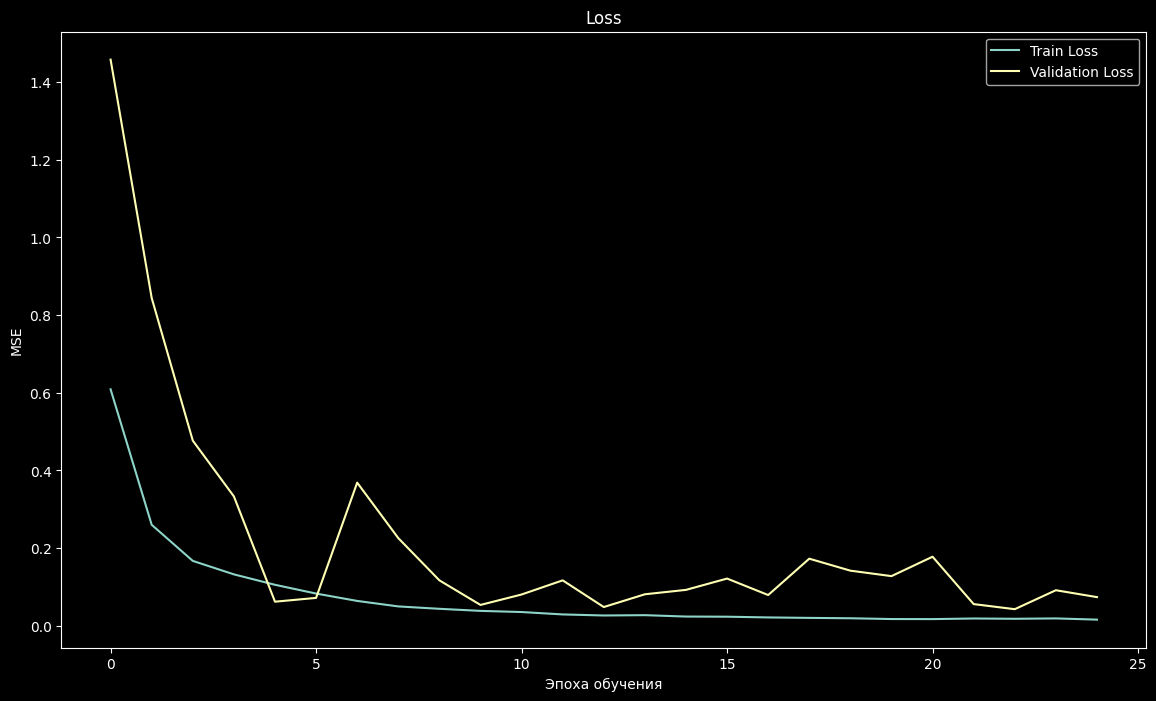

In [794]:
plot_hist(history)

In [795]:
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step
MAE: 0.2375
MSE: 0.0734
R2: 0.3663


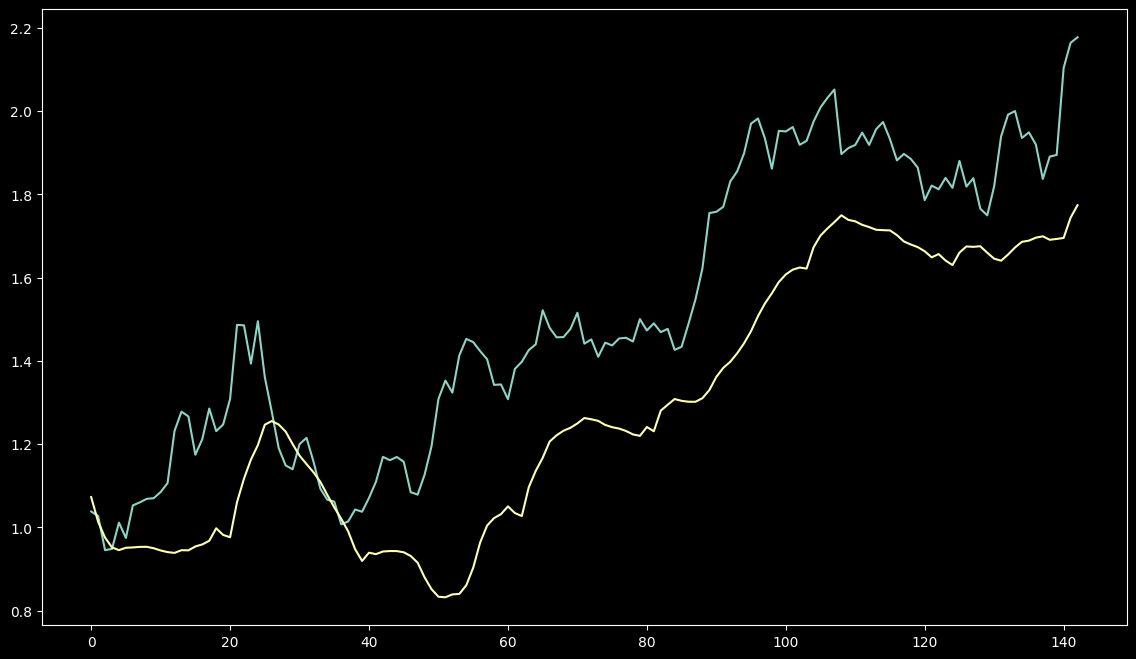

In [796]:
plt.figure(figsize=(14, 8))

plt.plot(y_test, label='Реальные значения')
plt.plot(y_pred, label='Предсказанные значения')

plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step


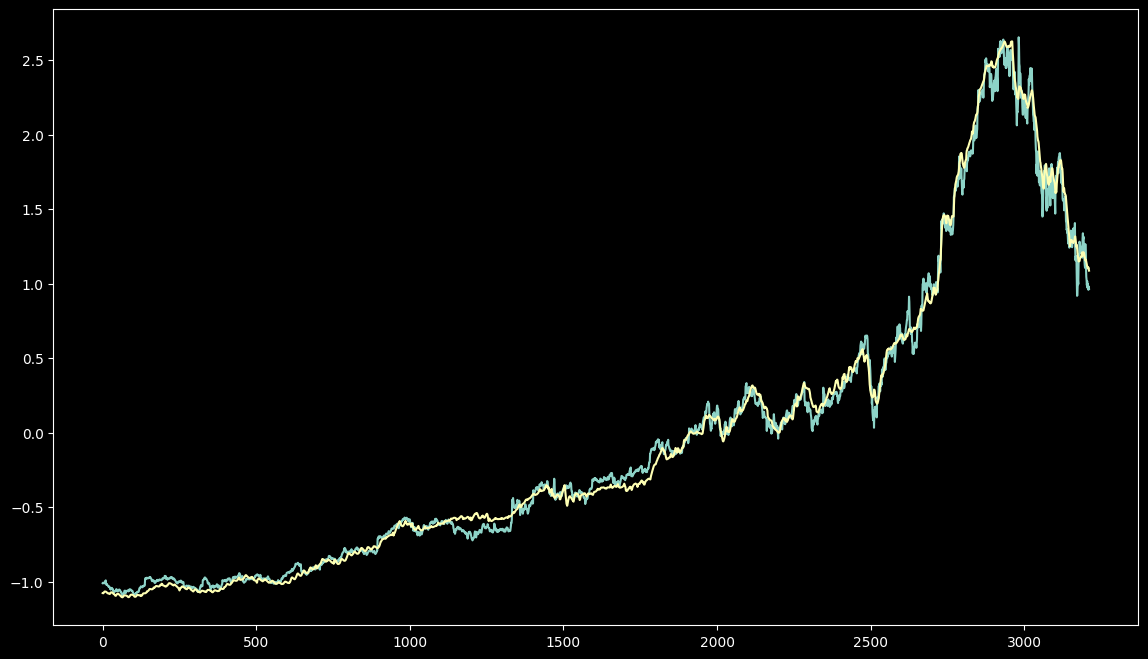

In [797]:
plt.figure(figsize=(14, 8))

plt.plot(y_train, label='Реальные значения')
plt.plot(model.predict(x_train), label='Предсказанные значения')

plt.show()

Модели хорошо улавливают тренд, но не лучшим образом справляются на малом временном диапазоне